In [1]:
import numpy as np
from packaging import version
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import binom
from scipy.stats import expon
from scipy.stats import geom
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_array, check_is_fitted
import pandas as pd

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형 회귀

## 정규 방정식

In [6]:
import numpy as np

np.random.seed(42)  # 코드 예제를 재현 가능하게 만들기 위해
m = 100  # 샘플 개수
X = 2 * np.random.rand(m, 1)  # 열 벡터
y = 4 + 3 * X + np.random.randn(m, 1)  # 열 벡터

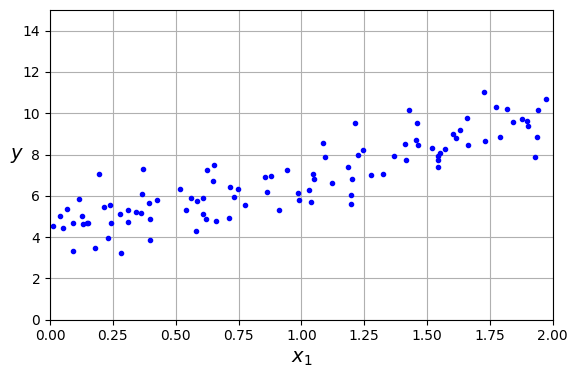

In [7]:
# 추가 코드 - 그림 4-1 생성 및 저장

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

In [8]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # 각 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [9]:
y

array([[ 6.33428778],
       [ 9.40527849],
       [ 8.48372443],
       [ 5.60438199],
       [ 4.71643995],
       [ 5.29307969],
       [ 5.82639572],
       [ 8.67878666],
       [ 6.79819647],
       [ 7.74667842],
       [ 5.03890908],
       [10.14821022],
       [ 8.46489564],
       [ 5.7873021 ],
       [ 5.18802735],
       [ 6.06907205],
       [ 5.12340036],
       [ 6.82087644],
       [ 6.19956196],
       [ 4.28385989],
       [ 7.96723765],
       [ 5.09801844],
       [ 5.75798135],
       [ 5.96358393],
       [ 5.32104916],
       [ 8.29041045],
       [ 4.85532818],
       [ 6.28312936],
       [ 7.3932017 ],
       [ 4.68275333],
       [ 9.53145501],
       [ 5.19772255],
       [ 4.64785995],
       [ 9.61886731],
       [ 7.87502098],
       [ 8.82387021],
       [ 5.88791282],
       [ 7.0492748 ],
       [ 7.91303719],
       [ 6.9424623 ],
       [ 4.69751764],
       [ 5.80238342],
       [ 5.34915394],
       [10.20785545],
       [ 6.34371184],
       [ 7

In [10]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [11]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # 각 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

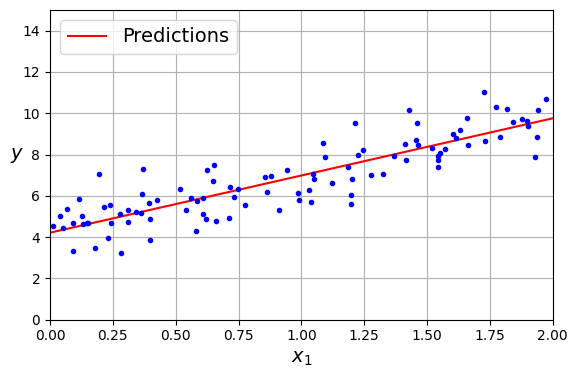

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # 추가 코드
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# 추가 코드 - 그림 4-2를 꾸미고 저장합니다.
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [14]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [16]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# 경사 하강법

## 배치 경사 하강법

In [17]:
eta = 0.1  # 학습률
n_epochs = 1000
m = len(X_b)  # 샘플 개수

np.random.seed(42)
theta = np.random.randn(2, 1)  # 모델 파라미터를 랜덤하게 초기화합니다

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [18]:
theta

array([[4.21509616],
       [2.77011339]])

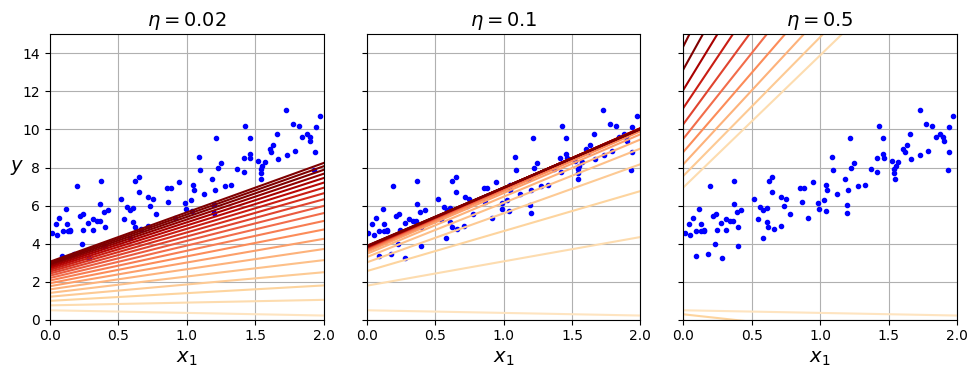

In [19]:
# 추가 코드 - 그림 4-8을 생성하고 저장합니다.

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

In [20]:
theta_path_sgd = []  # 추가 코드 - 다음 그림을 그리기 위해 매개변수 공간에서 theta의 경로를 저장합니다.

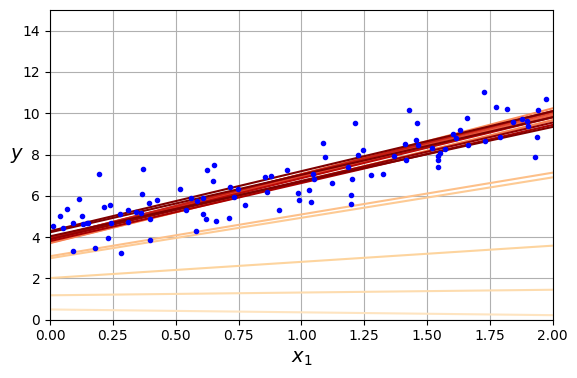

In [21]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

n_shown = 20  # 추가 코드 - 아래 그림을 생성하는 데만 필요합니다.
plt.figure(figsize=(6, 4))  # 추가 코드

for epoch in range(n_epochs):
    for iteration in range(m):

        # 추가 코드 - 이 네 라인은 그림을 생성하는 데 사용됩니다.
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # SGD의 경우 m으로 나누지 않습니다
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # 추가 코드 - 그림을 생성하기 위해

# 추가 코드 - 이 섹션은 그림 4-10을 꾸미고 저장합니다.
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()